In [1]:
import sys
sys.path.append('/home/adelsondias/Repos/predspot')
import predspot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely

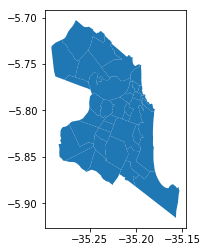

In [2]:
districts = gpd.read_file('/home/adelsondias/Repos/educational-analytics/data/bairros_natal_populacao2016.geojson')

districts.plot()

In [3]:
folder = '/home/adelsondias/Repos/educational-analytics/data/'

students = pd.read_csv(folder+'alunos.csv')
print(students.shape)
students.head()

(65524, 14)


,ID,direc,municipio,escola,etapa,serie,turno,turma,disciplina,frequencia,media_final,situacao,latitude,longitude
0,9599,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,92.5,6.9,APROVADO,-5.885477,-35.168400
1,9595,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,6.6,APROVADO,-5.739230,-35.243496
2,9606,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,6.1,APROVADO,-5.736580,-35.242956
3,93948,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,7.6,APROVADO,-5.742527,-35.242607
4,9582,01ª DIREC - NATAL,NATAL,CE ALFERES TIRADENTES,ENSINO FUNDAMENTAL - ANOS FINAIS,6º Ano,MATUTINO,EFAFM6A,Língua Portuguesa,100.0,7.1,APROVADO,-5.742393,-35.244102


In [4]:
students['serie'] = students['serie'].apply(lambda x: x.upper())
students = students.loc[students['etapa'].isin(students['etapa'].value_counts()[:5].index)]
students['etapa'] = students['etapa'].replace({'CEJA ENSINO MEDIO': 'EJA - ENSINO MÉDIO'})
students['serie'] = students['serie'].replace({'2º PERÍODO (2ª SÉRIE)':'2ª SÉRIE',
 '3º PERÍODO (3ª SÉRIE)':'3ª SÉRIE',
 '1º PERÍODO (1ª SÉRIE)':'1ª SÉRIE'                                 
})
students['media_final'] = students['media_final'].astype(float)
students['frequencia'] = students['frequencia'].astype(float)

In [5]:
students['geometry'] = students.apply(lambda x: shapely.geometry.Point([x['longitude'],x['latitude']]), axis=1)
students = gpd.GeoDataFrame(students)

sd = gpd.sjoin(students, districts, op='within')
sd = sd.dropna()

### geofeatures

In [6]:
# import json
import urllib
import fiona, shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import json
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold, GridSearchCV


def make_grid(bbox, resolution=0.5):
    nlon = int(np.ceil((bbox['east']- bbox['west'])/(resolution/111.32)))
    nlat = int(np.ceil((bbox['north']- bbox['south'])/(resolution/110.57)))
    lon = np.linspace(float(bbox['west']), float(bbox['east']), nlon)
    lat = np.linspace(float(bbox['south']), float(bbox['north']), nlat)
    lonv, latv = np.meshgrid(lon,lat)
    grid = np.vstack([lonv.ravel(), latv.ravel()]).T
    grid = gpd.GeoDataFrame(grid, geometry=[shapely.geometry.Point(xy) for xy in grid],crs={'init': 'epsg:4326'})
    grid.rename(columns={0:'lon',1:'lat'}, inplace=True)
    return grid, lonv, latv

def gridsearch_kde_params(points, n_samples=None):
    if n_samples is None:
        n_samples = points.shape[0]
    pgrid = {'bandwidth': np.logspace(-1, -5, 10),
             'kernel':['gaussian','linear','exponential','tophat'],
             'metric':['haversine']}
    gscv = GridSearchCV(KernelDensity(), pgrid,
                        cv=5, n_jobs=-1, iid=False)
    gscv.fit(points[['lon','lat']].sample(int(n_samples),random_state=0));
    return gscv.best_params_

def overpass_get_points_by_key(folder, bbox, key, item): #keys: 'amenity', 'building', 'highway', 'tourism', 'historic'
    if "OSM_points_{}-{}".format(key, item) in os.listdir(folder):
        return gpd.read_file("{}/OSM_points_{}-{}".format(folder,key, item).replace('//','/'))
    else:
        print('Querying {} points from Overpass API...'.format(key+"-"+item))
        query_string = ''.join("node[\"{}\"=\"{}\"]{};way[\"{}\"=\"{}\"]{};relation[\"{}\"=\"{}\"]{};".format(key, item, bbox, key, item, bbox, key, item, bbox)).replace("=\"*\"",'')
        query_string = "[out:json][timeout:50];({});out+geom;".format(query_string)
        result = json.loads(urllib.request.urlopen('http://overpass-api.de/api/interpreter?data='+query_string).read())
        points = []
        for x in result['elements']:
            elem = {}
            if x['type']=='node':
                lon, lat = x['lon'],x['lat']
            else:
                lon, lat = x['bounds']['minlon'], x['bounds']['minlat']
            elem['geometry'] = shapely.geometry.Point([lon,lat])
            elem['id'] = x['id']
            elem['tag'] = key+'_'+x['tags'][key]
            points.append(elem)
        points = gpd.GeoDataFrame(points,crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))
        points.set_index('id', inplace=True)
        if item=='*':
            points['tag'] = [key+'_*']*points.shape[0]
        # caching points df to output_folder
        points.to_file('{}/OSM_points_{}-{}'.format(folder,key,item).replace('//','/'))
        return points

def overpass_get_lines_by_key(folder, bbox, key, item, aspoints=False):
    if "OSM_lines_{}-{}".format(key, item) in os.listdir(folder):
        return gpd.read_file("{}/OSM_lines_{}-{}".format(folder,key, item).replace('//','/'))
    else:
        print('Querying {} lines from Overpass API...'.format(key+"-"+item))
        query_string = ''.join("way[\"{}\"=\"{}\"]{};".format(key, item, bbox))
        query_string = "[out:json][timeout:50];({});out+geom;".format(query_string)
        result = json.loads(urllib.request.urlopen('http://overpass-api.de/api/interpreter?data='+query_string).read())
        lines = []
        for x in result['elements']:
            elem = {}
            try: # it must have at least ['lon', 'lat', 'id', 'tags']
                elem['geometry'] = shapely.geometry.LineString([(i['lon'],i['lat']) for i in x['geometry']])
                elem['id'] = x['id']
                elem['tag'] = "{}_{}".format(key,x['tags'][key])
            except:
                continue
            lines.append(elem)
        lines = gpd.GeoDataFrame(lines)
        lines.set_index('id', inplace=True)
        if aspoints:
            l1, l2 = [], []
            for x in range(lines.shape[0]):
                tmp = [shapely.geometry.Point(i) for i in list(lines.iloc[x]['geometry'].coords)]
                l1 += tmp
                l2 += [lines.iloc[x]['tag']]*len(tmp)
            lines = gpd.GeoDataFrame({'geometry':l1, 'tag':l2})
        lines.to_file('{}/OSM_lines_{}-{}'.format(folder,key,item).replace('//','/'))
    return lines


class Grid(object):

    def __init__(self, resolution):
        self.resolution = resolution

    def fit(self, city_shape):
        self.city_shape = city_shape
        self.data, self.lonv, self.latv = make_grid(bbox={'north':city_shape.bounds.max().values[3],
                                                                'east':city_shape.bounds.max().values[2],
                                                                'south':city_shape.bounds.min().values[1],
                                                                'west':city_shape.bounds.min().values[0]},
                                                          resolution=self.resolution)
        self.data = gpd.sjoin(self.data, self.city_shape, how='inner', op='within')
        self.data = self.data[~self.data.index.duplicated(keep='first')]
        return self



class OSMHawk(object):

    def __init__(self, bbox, folder):
        if type(bbox)==dict:
            self.bbox = '({},{},{},{})'.format(bbox['south'], bbox['west'], bbox['north'], bbox['east'])
        else:
            self.bbox = bbox
        self.folder = folder
    def transform(self, points=None, lines=None):
        pdf = pd.DataFrame()
        if points is not None:
            for key in points:
                for item in points[key]:
                    pdf = pdf.append(overpass_get_points_by_key(self.folder, self.bbox, key, item))
        pdf['lat'] = pdf.geometry.y
        pdf['lon'] = pdf.geometry.x
        ldf = pd.DataFrame()
        if lines is not None:
            for key in lines:
                for item in lines[key]:
                    ldf = ldf.append(overpass_get_lines_by_key(self.folder, self.bbox, key, item, aspoints=True))
        ldf['lat'] = ldf.geometry.y
        ldf['lon'] = ldf.geometry.x
        return pdf, ldf
    
class GeoFeatures(object):

    def __init__(self, landmarks, kde_params):
        self.landmarks = landmarks
        self.kde_params = {}
        if kde_params=='auto':
            for ptype in self.landmarks.pdf['tag'].unique():
                self.kde_params[ptype] = 'auto'
            for ltype in self.landmarks.ldf['tag'].unique():
                self.kde_params[ltype] = 'auto'
        else:
            self.kde_params = kde_params

    def fit_transform(self, grid):
        label = "{}_{}_{}".format(grid.shape[0],
                 self.landmarks.pdf['tag'].unique().shape[0],
                 self.landmarks.ldf['tag'].unique().shape[0])
        if 'GF_{}.csv'.format(label) in os.listdir(self.landmarks.osm_folder):
            X = pd.read_csv(self.landmarks.osm_folder+'/GF_{}.csv'.format(label).replace('//','/')).set_index('place')
        else:
            X = pd.DataFrame(index=grid.index)
            for ptype in self.landmarks.pdf['tag'].unique():
                p = self.landmarks.pdf.loc[self.landmarks.pdf['tag']==ptype]
                kde = predspot.feature_engineering.KDE(grid, params=self.kde_params[ptype]).fit(p)
                self.kde_params[ptype] = kde.params
                X = X.join(kde.transform(p, label='kde:'+ptype), on='place')
            for ltype in self.landmarks.ldf['tag'].unique():
                l = self.landmarks.ldf.loc[self.landmarks.ldf['tag']==ltype]
                kde = predspot.feature_engineering.KDE(grid, params=self.kde_params[ltype]).fit(l, 500)
                self.kde_params[ltype] = kde.params
                X = X.join(kde.transform(l, label='kde:'+ltype), on='place')
            X.to_csv(self.landmarks.osm_folder+'/GF_{}.csv'.format(label))
        return X


# # TESTS
# bbox = {'west':-35.29122515, 'south':-5.91582226, 'east':-35.153019, 'north':-5.702727}
# ol = OSMLeech(bbox, folder='/home/adelsondias/Repos/crime-hotspots/predspot/tests')
# points = {
#     'amenity':['hospital','school']
# }
# lines = {
#     'highway':['primary','secondary']
# }
# ol.transform(points, lines)


In [7]:
bbox =  {'north':districts.bounds.max().values[3],
         'east':districts.bounds.max().values[2],
         'south':districts.bounds.min().values[1],
         'west':districts.bounds.min().values[0]}

hawk = OSMHawk(bbox, folder='/home/adelsondias/Repos/educational-analytics/data/')

In [8]:
pdf, ldf = hawk.transform(points={
    'amenity':['hospital', 'place_of_worship', 'police'],
    'leisure':['*'],
    'tourism':['*'],
    'shop':['*'],
    'highway':['bus_stop']
}, lines={
    'highway':['residential', 'primary']
})

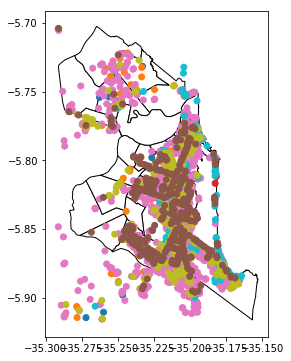

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,6))
districts.plot(ax=ax, color='white', edgecolor='black')
pdf.plot(column='tag', ax=ax)

In [10]:
grid = Grid(0.5).fit(districts)

In [12]:
landmarks = predspot.data_preparation.Landmarks(districts, '/home/adelsondias/Repos/educational-analytics/data/').fit(points={
                    'amenity':['hospital', 'place_of_worship', 'police'],
                    'leisure':['*'],
                    'tourism':['*'],
                    'shop':['*'],
                    'highway':['bus_stop']
                }, lines={
                    'highway':['residential', 'primary']
})

In [13]:
gf = GeoFeatures(landmarks,
                  {'amenity_hospital':{'bandwidth':0.5/69, 'kernel':'exponential'},
                   'amenity_place_of_worship':{'bandwidth':1.5/69, 'kernel':'exponential'},
                   'amenity_police':{'bandwidth':1.5/69, 'kernel':'exponential'},
                   'leisure_*':{'bandwidth':1/69, 'kernel':'exponential'},
                   'tourism_*':{'bandwidth':1.5/69, 'kernel':'exponential'},
                   'shop_*':{'bandwidth':2/69, 'kernel':'exponential'},
                   'highway_bus_stop':{'bandwidth':1.5/69, 'kernel':'exponential'},
                   'highway_residential':{'bandwidth':0.5/69, 'kernel':'exponential'},
                   'highway_primary':{'bandwidth':2/69, 'kernel':'exponential'},
                  })
gf_ = gf.fit_transform(\
    sd.rename({'longitude':'lon', 'latitude':'lat'}, axis=1))
#                                    grid.data)

In [70]:
gf_grid = gf.fit_transform(\
#     sd.rename({'longitude':'lon', 'latitude':'lat'}, axis=1))
                                   grid.data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41dec1eb70>,
      dtype=object)

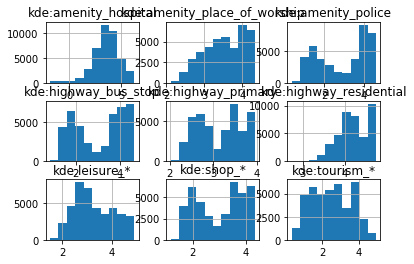

In [14]:
gf_.hist()

In [15]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

# Model selection
pgrid = {
    'n_estimators': [100, 200],
    'max_depth':[3, 5],
    'max_features':[0.8, 1]
}
reg = RandomizedSearchCV(RandomForestRegressor(), param_distributions=pgrid, cv=5, n_iter=1, n_jobs=-1,
                        scoring='neg_mean_squared_error')
reg.fit(gf_.join(sd['frequencia']),sd['media_final'])
print('RMSE:', np.sqrt(-reg.best_score_))

RMSE: 2.4666724569564353


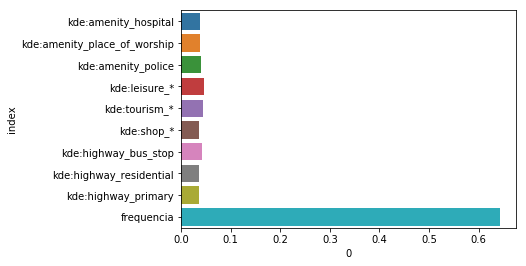

In [16]:
d = pd.DataFrame(reg.best_estimator_.feature_importances_, gf_.join(sd['frequencia']).columns)

import seaborn as sns
sns.barplot(data=d.reset_index(), x=0, y='index')

In [17]:
df = gf_.join(sd[['frequencia','media_final','serie','situacao','disciplina','turno','REG_ADM','BAIRRO','populacao2016','densidade2016','taxa2000-2016']])

### crime

In [18]:
from sklearn.neighbors import KernelDensity

crimes_data = {}
X_ = pd.DataFrame()
for crimetag in ['burglary','violent-lethal','drugs']:
    print(crimetag)
    crimes_data[crimetag] = pd.read_csv(folder+'natal_crimes_{}.csv'.format(crimetag))
    kde = KernelDensity(bandwidth=0.1/69, kernel='exponential', metric='haversine').fit(crimes_data[crimetag][['lon','lat']].sample(frac=0.5))
    X = pd.DataFrame(kde.score_samples(sd[['longitude','latitude']]),
                         index=sd.index, columns=['kde_{}'.format(crimetag)])
    X_ = pd.concat([X_,X],axis=1)

burglary
violent-lethal
drugs


In [19]:
df = df.join(X_)

### correlation analysis

In [20]:
df.columns

fatores = list(gf_.columns) + list(X_.columns)
fatores += ['frequencia','media_final','densidade2016','taxa2000-2016']

cats = ['serie','situacao','disciplina','turno','REG_ADM','BAIRRO']

In [49]:
df['BAIRRO'].unique().shape

(36,)

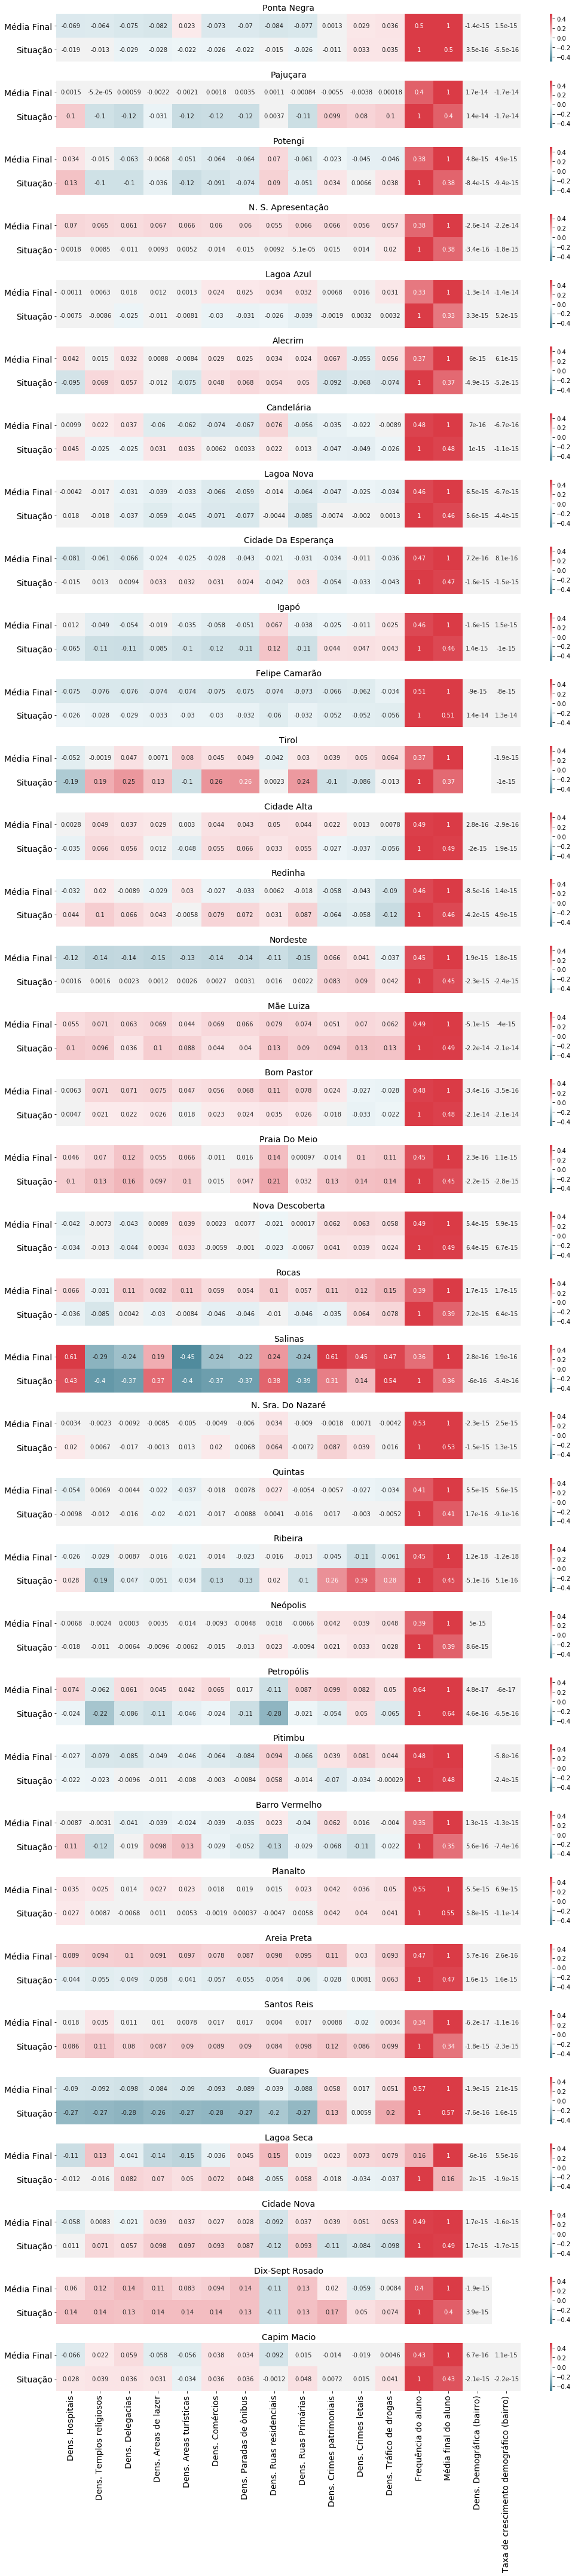

In [52]:
fig, ax = plt.subplots(figsize=(15,60), nrows=len(df['BAIRRO'].unique()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

for i, bairro in enumerate(df['BAIRRO'].unique()):
    df_ = df.loc[df['BAIRRO']==bairro, fatores].corr()[['media_final','frequencia']]
    sns.heatmap(df_.transpose(), cmap=cmap, ax=ax[i], vmin=-0.5, vmax=0.5, annot=True)
    
    ax[i].set_yticklabels(['Média Final','Situação'], rotation = 0, ha="right", fontsize=14)
    ax[i].set_title(bairro.title(), fontsize=14)
    
    if i== df['BAIRRO'].unique().shape[0]-1:
        ax[i].set_xticklabels(['Dens. Hospitais','Dens. Templos religiosos','Dens. Delegacias',
                                'Dens. Areas de lazer', 'Dens. Areas turísticas', 'Dens. Comércios',
                                'Dens. Paradas de ônibus', 'Dens. Ruas residenciais', 'Dens. Ruas Primárias',
                                'Dens. Crimes patrimoniais', 'Dens. Crimes letais', 'Dens. Tráfico de drogas',
                                'Frequência do aluno', 'Média final do aluno',
                                'Dens. Demográfica (bairro)', 'Taxa de crescimento demográfico (bairro)'], fontsize=14);
    else:
        ax[i].get_xaxis().set_visible(False)
        
plt.tight_layout()
plt.savefig('correlograma_bairro.pdf',dpi=200)

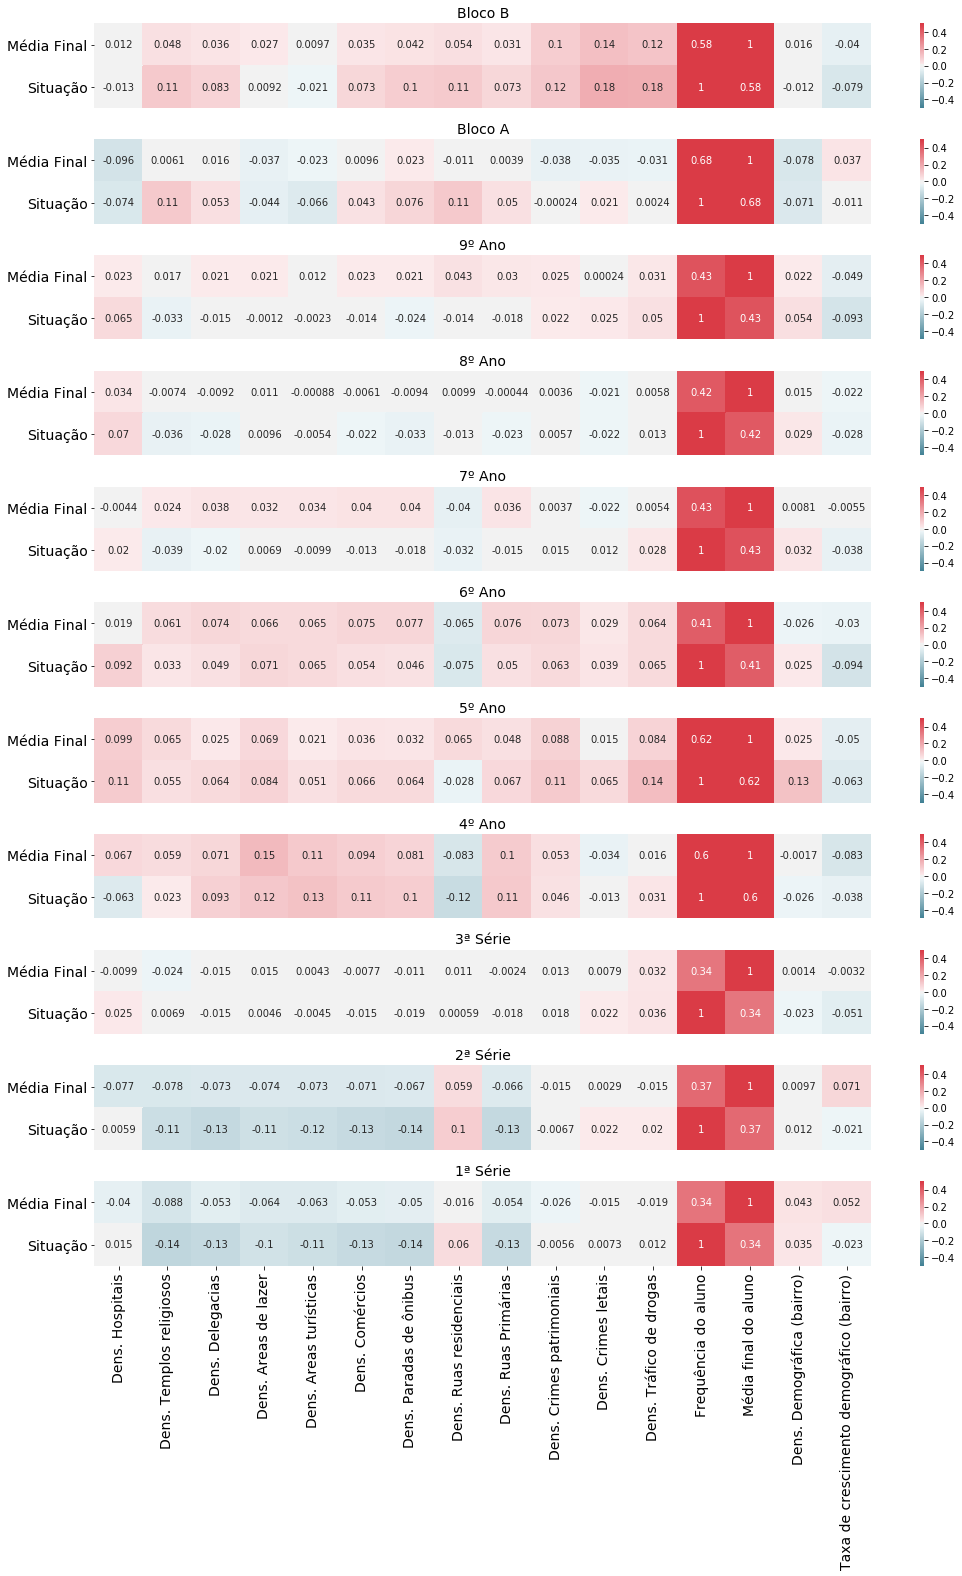

In [67]:
fig, ax = plt.subplots(figsize=(15,22), nrows=len(df['serie'].unique()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

for i, serie in enumerate(np.sort(df['serie'].unique())[::-1]):
    df_ = df.loc[df['serie']==serie, fatores].corr()[['media_final','frequencia']]
    sns.heatmap(df_.transpose(), cmap=cmap, ax=ax[i], vmin=-0.5, vmax=0.5, annot=True)
    
    ax[i].set_yticklabels(['Média Final','Situação'], rotation = 0, ha="right", fontsize=14)
    ax[i].set_title(serie.title(), fontsize=14)
    
    if i== df['serie'].unique().shape[0]-1:
        ax[i].set_xticklabels(['Dens. Hospitais','Dens. Templos religiosos','Dens. Delegacias',
                                'Dens. Areas de lazer', 'Dens. Areas turísticas', 'Dens. Comércios',
                                'Dens. Paradas de ônibus', 'Dens. Ruas residenciais', 'Dens. Ruas Primárias',
                                'Dens. Crimes patrimoniais', 'Dens. Crimes letais', 'Dens. Tráfico de drogas',
                                'Frequência do aluno', 'Média final do aluno',
                                'Dens. Demográfica (bairro)', 'Taxa de crescimento demográfico (bairro)'], fontsize=14);
    else:
        ax[i].get_xaxis().set_visible(False)
        
plt.tight_layout()
plt.savefig('correlograma_serie.pdf',dpi=200)

In [77]:
gf_grid.columns

Index(['kde:amenity_hospital', 'kde:amenity_place_of_worship',
       'kde:amenity_police', 'kde:leisure_*', 'kde:tourism_*', 'kde:shop_*',
       'kde:highway_bus_stop', 'kde:highway_residential',
       'kde:highway_primary'],
      dtype='object')

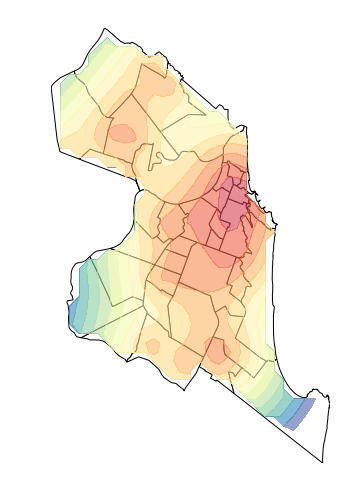

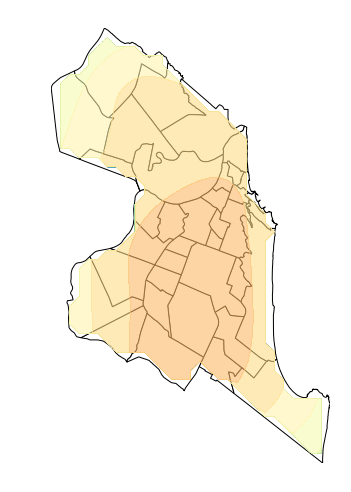

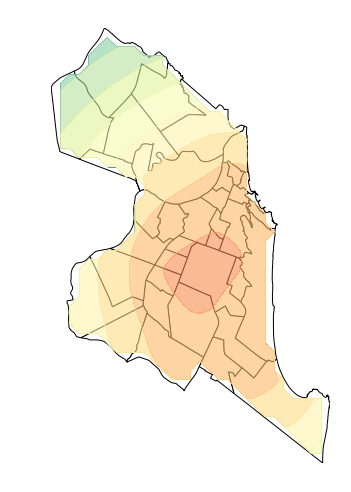

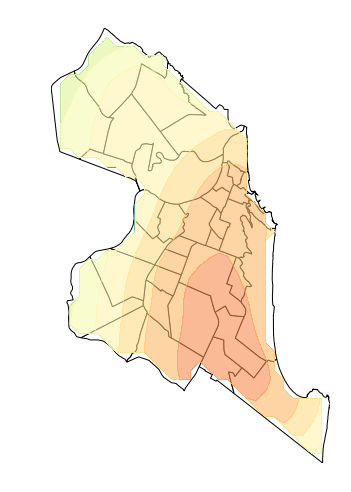

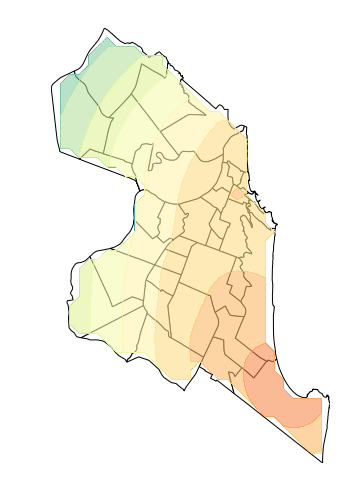

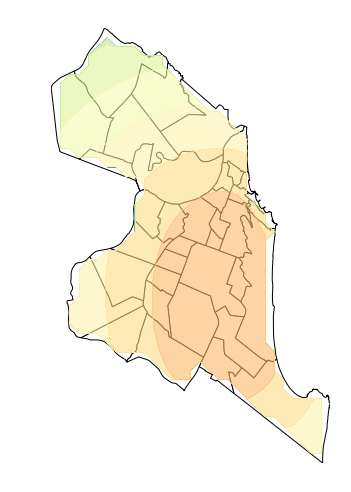

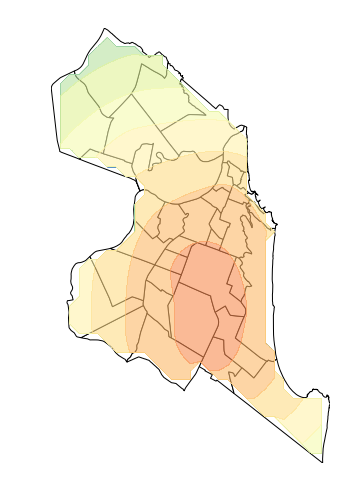

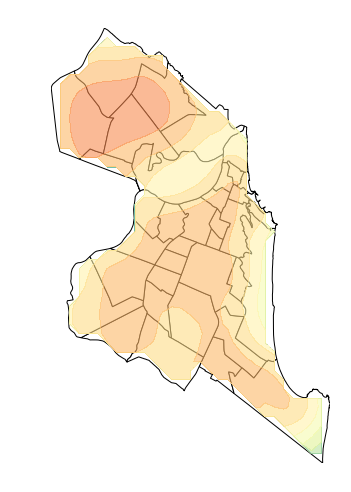

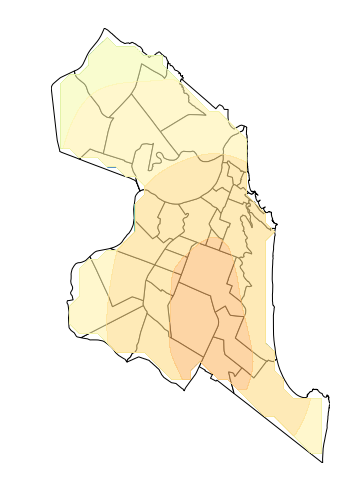

In [150]:
# geofeatures
for i in gf_grid.columns:
    fig, ax = plt.subplots(figsize=(5,8))
    predspot.utilities.plot_kde(districts, grid, gf_grid[i], ax=ax, fig_path='plots/{}.pdf'.format(i))

In [116]:
N = 50
for i in grid.data.index:
    nearneighbors = sd.loc[sd['geometry'].distance(grid.data.loc[i,'geometry']).sort_values()[:N].index, 'media_final']
    grid.data.loc[i,'media_final_mean'] = nearneighbors.mean()
    grid.data.loc[i,'media_final_std'] = nearneighbors.std()
grid.data.columns.name='place'

In [145]:
def plot_kde(shape, grid, kde, ax, kmin, kmax, fig_path=False, geojson_path=False):
    import numpy as np
    import geojsoncontour
    Z = np.zeros(grid.lonv.shape[0]*grid.lonv.shape[1]) - 999
    Z[kde.reset_index()['place'].unique()] = kde.values.ravel()
    Z = Z.reshape(grid.lonv.shape)
    shape.plot(ax=ax, color='white', edgecolor='black')
    contourf = plt.contourf(grid.lonv, grid.latv, Z, levels=np.linspace(kmin, kmax, 15), alpha=0.6, cmap=plt.cm.Spectral_r)
    plt.axis('off')
    if fig_path:
        plt.savefig(fig_path)
    if geojson_path:
        geojsoncontour.contourf_to_geojson(contourf=contourf, geojson_filepath=geojson_path, fill_opacity=0.5)
    plt.show()
    return

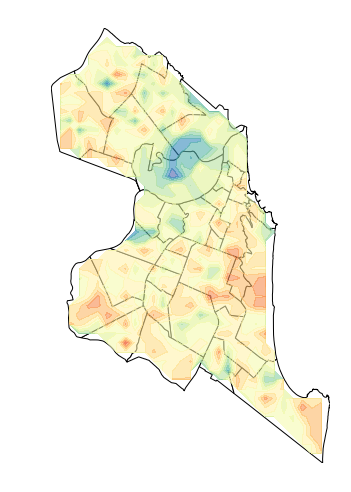

In [151]:
grid.data['media_final'].index.name='place'
fig, ax = plt.subplots(figsize=(5,8))
plot_kde(districts, grid, grid.data['media_final_mean'], ax=ax, kmin=3, kmax=8, 
         fig_path='plots/interpolation_media-final_mean.pdf')

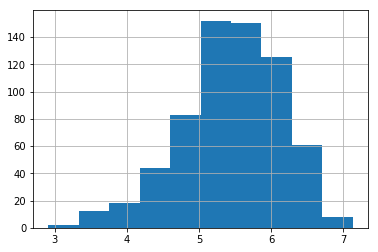

In [153]:
grid.data['media_final_mean'].hist()
plt.savefig('plots/hist_interpolation_media-final_mean.pdf')

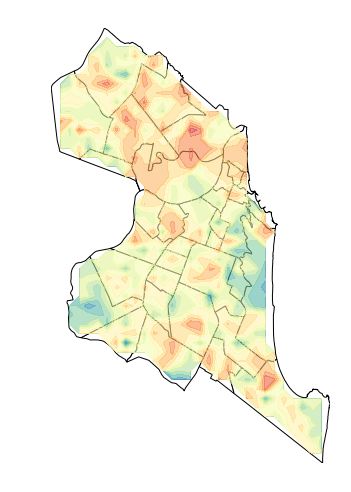

In [152]:
grid.data['media_final'].index.name='place'
fig, ax = plt.subplots(figsize=(5,8))
plot_kde(districts, grid, grid.data['media_final_std'], ax=ax, kmin=1, kmax=4, 
         fig_path='plots/interpolation_media-final_std.pdf')

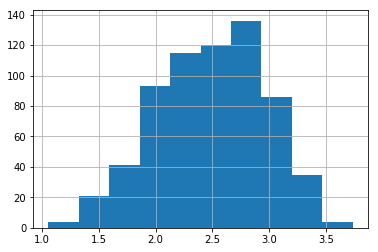

In [147]:
grid.data['media_final_std'].hist()